<a href="https://colab.research.google.com/github/Saumi18/Music-Genre-Classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload the features_3_sec.csv file below:

In [1]:
#Upload the features_3_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_3_sec.csv to features_3_sec.csv


Upload the feature_30_sec.csv file below:

In [2]:
#Upload the feature_30_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_30_sec.csv to features_30_sec.csv


- Setting Up & Loading Data
- Feature Scaling & Preprocessing

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load datasets
df1 = pd.read_csv("features_3_sec.csv")
df2 = pd.read_csv("features_30_sec.csv")

# Combine both datasets (assumes they have same structure)
df = pd.concat([df1, df2], ignore_index=True)

# Drop unnecessary columns
df = df.drop(columns=["filename", "length"])

# Encode genre labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Separate features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: Train (70%) and Test (30%) from the combined dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

##Feature Extraction

In [ ]:
import librosa
import numpy as np
import os

def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, duration=30)

    features = {}
    features['filename'] = os.path.basename(file_path)
    features['length'] = len(y)

    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_var'] = np.var(chroma_stft)

    # RMS
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    # Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spec_centroid)
    features['spectral_centroid_var'] = np.var(spec_centroid)

    # Spectral Bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spec_bw)
    features['spectral_bandwidth_var'] = np.var(spec_bw)

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_var'] = np.var(rolloff)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate_mean'] = np.mean(zcr)
    features['zero_crossing_rate_var'] = np.var(zcr)

    # Harmony & Perceptr
    harm, perc = librosa.effects.hpss(y)
    features['harmony_mean'] = np.mean(harm)
    features['harmony_var'] = np.var(harm)
    features['perceptr_mean'] = np.mean(perc)
    features['perceptr_var'] = np.var(perc)

    # Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    features['tempo'] = tempo

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfcc[i-1])
        features[f'mfcc{i}_var'] = np.var(mfcc[i-1])

    return features

# Example usage:
# features = extract_features("your_audio_file.wav")
# print(features)

## Model 1 : KNN

In [12]:
import numpy as np
import pandas as pd

class CustomKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _euclidean_distance(self, point1, point2):
        """Calculates the Euclidean distance between two points."""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _get_k_nearest_neighbors(self, test_point):
        """Finds the k-nearest neighbors of a test point in the training data."""
        distances = [self._euclidean_distance(train_point, test_point) for train_point in self.X_train]
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train.iloc[k_nearest_indices]
        return k_nearest_labels

    def _predict_label(self, neighbors):
        """Predicts the label of a test point based on its k-nearest neighbors."""
        labels, counts = np.unique(neighbors, return_counts=True)
        return labels[np.argmax(counts)]

    def predict(self, X_test):
        """Predicts labels for all test points in X_test using KNN."""
        return [self._predict_label(self._get_k_nearest_neighbors(test_point)) for test_point in X_test]

#### Training and Accuracy

In [15]:
# Initialize
knn_model = CustomKNN(k=3)

# Train
knn_model.fit(X_train, y_train)

# Predict
predictions = knn_model.predict(X_test)

# Accuracy check
accuracy = np.mean(np.array(predictions) == np.array(y_test))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9090


#### Confusion Matrix

Confusion Matrix:
 [[313   2   8   0   1   3   0   0   1   2]
 [  0 340   1   1   0  10   0   0   0   0]
 [ 10   4 267   3   2   3   1   1   5   4]
 [  2   2  11 307   4   6   0   1   2   5]
 [  1   4   8   4 289   1   1   8   3   1]
 [  9  23   6   1   3 299   0   1   1   0]
 [  2   0   0   2   0   0 309   0   0   6]
 [  1   3  11  11   5   2   0 278   4   3]
 [  2   2   8   6   4   0   0   5 299   1]
 [  7   2  12  14   5   2   3   2   5 296]]
Precision: 0.9110
Recall: 0.9090


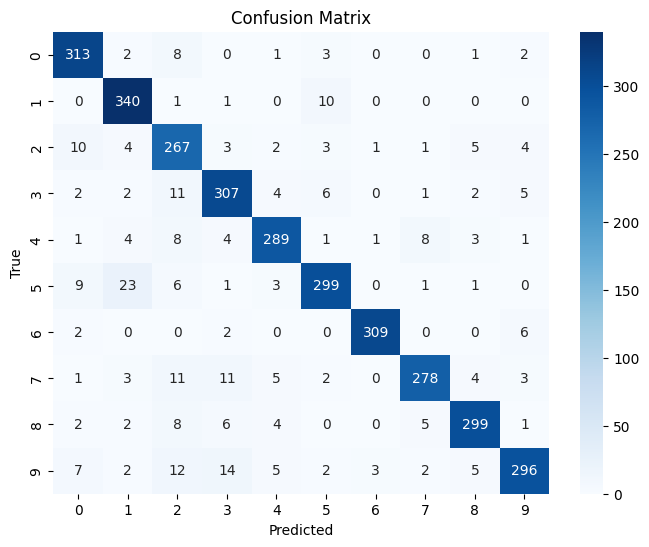

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict using custom KNN model
y_pred = knn_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Model 2: SVM

###From Scratch

Training class blues vs Rest...
Training class classical vs Rest...
Training class country vs Rest...
Training class disco vs Rest...
Training class hiphop vs Rest...
Training class jazz vs Rest...
Training class metal vs Rest...
Training class pop vs Rest...
Training class reggae vs Rest...
Training class rock vs Rest...
Testing class blues vs Rest...
Testing class classical vs Rest...
Testing class country vs Rest...
Testing class disco vs Rest...
Testing class hiphop vs Rest...
Testing class jazz vs Rest...
Testing class metal vs Rest...
Testing class pop vs Rest...
Testing class reggae vs Rest...
Testing class rock vs Rest...


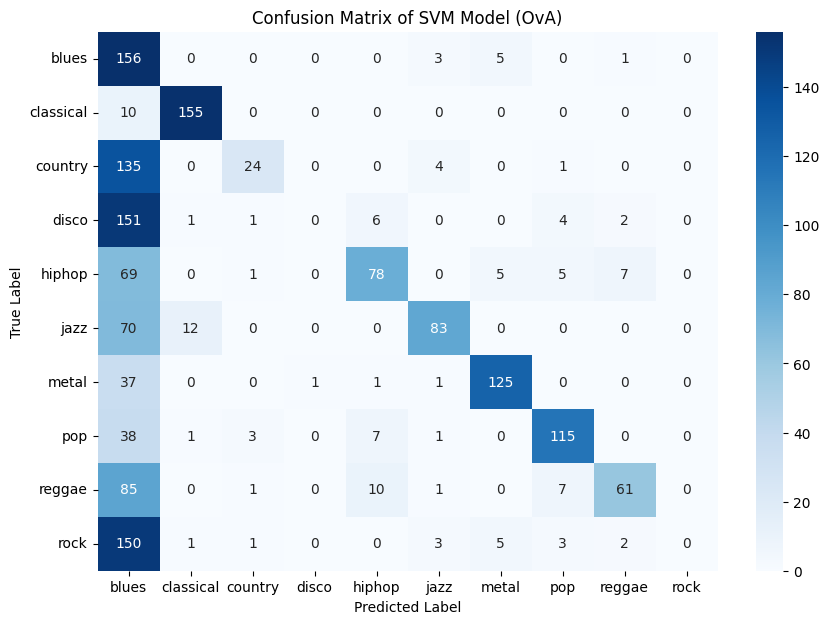

In [5]:
import random
from sklearn.metrics import confusion_matrix, classification_report

# Implementing SVM from scratch with gradient descent
class SVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y[idx]))
                    self.bias -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) - self.bias)

# One-vs-All (OvA) SVM Model
class MultiClassSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=2000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}

    def fit(self, X, y):
        unique_classes = np.unique(y)
        for cls in unique_classes:
            print(f"Training class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            y_binary = np.where(y == cls, 1, -1)
            svm = SVM(lr=self.lr, lambda_param=self.lambda_param, n_iters=self.n_iters)
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm

    def predict(self, X):
        predictions = {}
        for cls, svm in self.classifiers.items():
            print(f"Testing class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            predictions[cls] = svm.predict(X)
        return np.array([max(predictions, key=lambda k: predictions[k][i]) for i in range(X.shape[0])])

####Training and Accuracy

In [11]:
from sklearn.metrics import accuracy_score

# Train the custom SVM model
custom_svm = MultiClassSVM(lr=0.001, lambda_param=0.001, n_iters=2000)
custom_svm.fit(X_train, y_train)

# Make predictions
y_pred = custom_svm.predict(X_test)

# Evaluate model
conf_matrix = confusion_matrix(y_test, y_pred)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Custom SVM Model: {accuracy * 100:.2f}%")

Accuracy of Custom SVM Model: 48.33%


#### Confusion Matrix

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of SVM Model (OvA)")
plt.show()

#### Classification Report

In [10]:
from sklearn.metrics import classification_report

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       blues       0.17      0.95      0.29       165
   classical       0.91      0.94      0.93       165
     country       0.77      0.15      0.25       164
       disco       0.00      0.00      0.00       165
      hiphop       0.76      0.47      0.58       165
        jazz       0.86      0.50      0.64       165
       metal       0.89      0.76      0.82       165
         pop       0.85      0.70      0.77       165
      reggae       0.84      0.37      0.51       165
        rock       0.00      0.00      0.00       165

    accuracy                           0.48      1649
   macro avg       0.61      0.48      0.48      1649
weighted avg       0.61      0.48      0.48      1649



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Visual Testing Examples

In [ ]:
# Visual Testing: Few predictions with actual vs predicted
num_samples = 5
sample_indices = random.sample(range(len(X_test)), num_samples)

for i, idx in enumerate(sample_indices):
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
    print(f"Sample {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")

### Using Sklearn Library

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train scikit-learn's SVM
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train_encoded)

# Predict
y_pred_sklearn = clf.predict(X_test)

# Evaluate
conf_matrix = confusion_matrix(y_test_encoded, y_pred_sklearn)
print("Classification Report (scikit-learn SVM):")
print(classification_report(y_test_encoded, y_pred_sklearn, target_names=label_encoder.classes_))

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Scikit-learn SVM")
plt.show()

## Model 3 : Decision tree/Random Forest

#### From scratch

In [ ]:
import numpy as np
import math
from joblib import Parallel, delayed
from numba import njit

@njit
def gini_impurity(y):
    if len(y) == 0:
        return 0.0
    counts = np.bincount(y, minlength=np.max(y) + 1)
    probabilities = counts / len(y)
    return 1.0 - np.sum(probabilities**2)

@njit
def most_common_label(y):
    if len(y) == 0:
        return -1
    return np.bincount(y).argmax()

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.random_state = random_state
        self._rng = np.random.RandomState(random_state)
        self.trees = []

    def fit(self, X, y):
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        X = np.asarray(X)
        self.n_classes = len(set(y))
        self.trees = Parallel(n_jobs=-1)(
            delayed(self._grow_tree)(
                *self._bootstrap_sample(X, y)
            ) for _ in range(self.n_trees)
        )

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = self._rng.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _grow_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1 or len(y) < self.min_samples_split:
            return Node(value=most_common_label(y))

        feature_indices = self._rng.choice(X.shape[1], self.n_features or int(math.sqrt(X.shape[1])), replace=False)
        best_feature, best_threshold = self._best_split(X, y, feature_indices)

        if best_feature == -1:
            return Node(value=most_common_label(y))

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        if not np.any(left_mask) or not np.any(right_mask):
            return Node(value=most_common_label(y))

        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y, feature_indices):
        best_gain, best_feature, best_threshold = -1.0, -1, 0.0
        for feature_index in feature_indices:
            values = np.sort(np.unique(X[:, feature_index]))
            thresholds = (values[:-1] + values[1:]) / 2.0

            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if not np.any(left_mask) or not np.any(right_mask):
                    continue

                gain = gini_impurity(y) - (
                    (np.sum(left_mask) / len(y)) * gini_impurity(y[left_mask])
                    + (np.sum(right_mask) / len(y)) * gini_impurity(y[right_mask])
                )

                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature_index, threshold

        return best_feature, best_threshold

    def predict(self, X):
        X = np.asarray(X)
        tree_preds = Parallel(n_jobs=-1)(
            delayed(self._batch_predict_tree)(X, tree) for tree in self.trees
        )
        tree_preds = np.array(tree_preds)
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=self.n_classes).argmax(), axis=0, arr=tree_preds)

    def _batch_predict_tree(self, X, tree):
        return np.array([self._traverse_tree(x, tree) for x in X])

    def _traverse_tree(self, x, tree):
        while tree is not None and tree.value is None:
            if x[tree.feature_index] <= tree.threshold:
                tree = tree.left
            else:
                tree = tree.right
        return tree.value if tree is not None else -1

    def predict_proba(self, X):
        X = np.asarray(X)
        tree_preds = np.array([self._batch_predict_tree(X, tree) for tree in self.trees])
        proba = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.n_classes) / self.n_trees, axis=0, arr=tree_preds)
        return proba.T

#### Training and Accuracy

In [ ]:
# Initialize classifier
clf = RandomForestClassifier(n_trees=56, max_depth=17, min_samples_split=5)

# Fit the model to your training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8588588588588588


#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model using classification_report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       blues       0.83      0.86      0.84       208
   classical       0.93      0.98      0.95       203
     country       0.68      0.81      0.74       186
       disco       0.80      0.85      0.82       199
      hiphop       0.93      0.85      0.89       218
        jazz       0.88      0.92      0.90       192
       metal       0.88      0.96      0.92       204
         pop       0.89      0.91      0.90       180
      reggae       0.92      0.84      0.88       211
        rock       0.88      0.62      0.73       197

    accuracy                           0.86      1998
   macro avg       0.86      0.86      0.86      1998
weighted avg       0.86      0.86      0.86      1998



#### Confusion Matrix

Confusion Matrix:
 [[179   1  13   5   1   2   3   0   3   1]
 [  0 198   1   0   0   4   0   0   0   0]
 [ 17   1 150   3   0   7   1   2   2   3]
 [  3   3   6 169   2   0   4   4   2   6]
 [  5   1   7   5 186   0   5   8   1   0]
 [  2   9   3   1   0 177   0   0   0   0]
 [  1   0   0   2   1   0 195   0   1   4]
 [  0   0  10   1   3   0   0 163   2   1]
 [  3   1   8   9   4   1   2   5 177   1]
 [  6   0  21  17   3  10  11   2   5 122]]


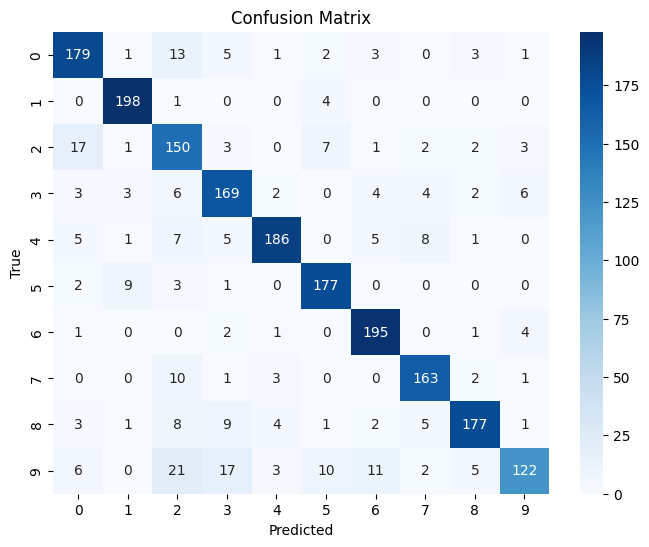

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### Visual Testing Examples

In [ ]:
import numpy as np
import random

# Select a few random test samples for visual testing
random_indices = random.sample(range(len(X_test)), 15)

y_test_samples = np.array(y_test)[random_indices]
y_pred_samples = clf.predict(X_test[random_indices])

# Print actual vs predicted labels
print("\nVisual Testing Examples (Random Forest):")
for i, idx in enumerate(random_indices):
    actual_label = label_encoder.inverse_transform([y_test_samples[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_samples[i]])[0]
    print(f"Example {i+1}: Actual = {actual_label}, Predicted = {predicted_label}")


Visual Testing Examples (Random Forest):
Example 1: Actual = classical, Predicted = classical
Example 2: Actual = reggae, Predicted = reggae
Example 3: Actual = country, Predicted = country
Example 4: Actual = pop, Predicted = pop
Example 5: Actual = jazz, Predicted = jazz
Example 6: Actual = hiphop, Predicted = hiphop
Example 7: Actual = disco, Predicted = disco
Example 8: Actual = metal, Predicted = metal
Example 9: Actual = pop, Predicted = pop
Example 10: Actual = blues, Predicted = blues
Example 11: Actual = hiphop, Predicted = pop
Example 12: Actual = hiphop, Predicted = hiphop
Example 13: Actual = disco, Predicted = rock
Example 14: Actual = hiphop, Predicted = hiphop
Example 15: Actual = rock, Predicted = blues


#### Using sklearn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Test Accuracy: 0.8869

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       208
           1       0.93      0.99      0.96       203
           2       0.76      0.85      0.80       186
           3       0.90      0.86      0.88       199
           4       0.94      0.89      0.91       218
           5       0.88      0.91      0.89       192
           6       0.90      0.96      0.93       204
           7       0.91      0.94      0.93       180
           8       0.90      0.87      0.89       211
           9       0.87      0.73      0.80       197

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



## Model 4: Gaussian Mixture Model (GMM) + Expectation Maximization

Train Accuracy: 37.36%
Test Accuracy: 39.24%


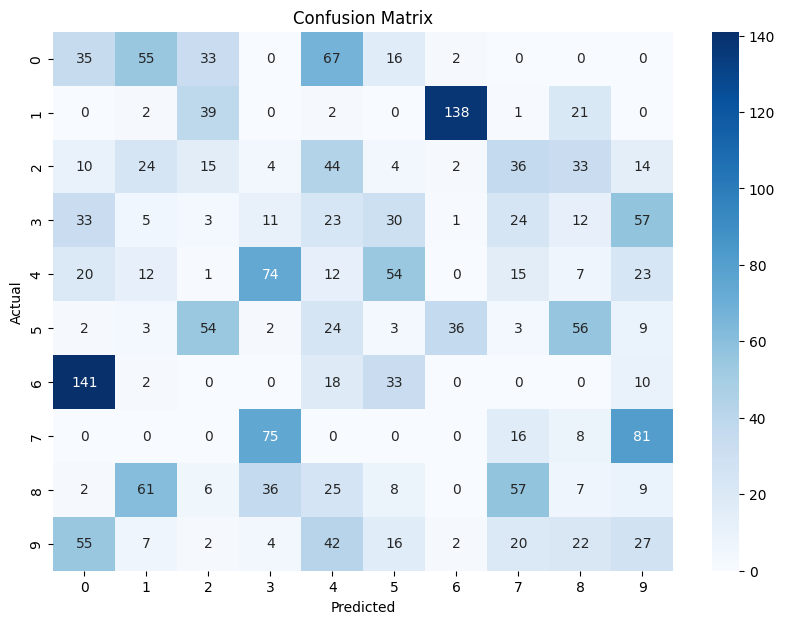

In [ ]:
# Model 4: Gaussian Mixture Model (GMM) + Expectation Maximization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode

def map_cluster_labels(y_true, y_pred):
    mapped_labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        mapped_labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return mapped_labels

class GaussianMixtureModel:
    def __init__(self, n_components, max_iters=500, tol=1e-5):
        self.n_components = n_components  # Number of clusters (genres)
        self.max_iters = max_iters  # Maximum iterations for EM
        self.tol = tol  # Convergence threshold

    def initialize_parameters(self, X):
        np.random.seed(42)
        n_samples, n_features = X.shape

        # K-Means based initialization for better cluster assignment
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.n_components, n_init=20, random_state=42)
        labels = kmeans.fit_predict(X)
        self.means = kmeans.cluster_centers_

        # Initialize covariances using full covariance matrices
        self.covariances = np.array([np.cov(X[labels == i].T) + np.eye(n_features) * 1e-6 for i in range(self.n_components)])

        # Initialize weights based on cluster sizes
        self.weights = np.array([np.sum(labels == i) for i in range(self.n_components)]) / n_samples

    def gaussian_pdf(self, X, mean, covariance):
        n = X.shape[1]
        det_cov = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)
        norm_factor = 1 / np.sqrt((2 * np.pi) ** n * det_cov)

        diff = X - mean
        exponent = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        return norm_factor * np.exp(-0.5 * exponent)

    def expectation_step(self, X):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * self.gaussian_pdf(X, self.means[i], self.covariances[i])

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # Normalize
        return responsibilities

    def maximization_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)  # Effective number of points in each cluster

        self.weights = N_k / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / N_k[:, None]

        for i in range(self.n_components):
            diff = X - self.means[i]
            weighted_diff = responsibilities[:, i][:, None] * diff
            self.covariances[i] = np.dot(weighted_diff.T, diff) / N_k[i] + np.eye(X.shape[1]) * 1e-6  # Regularization

    def fit(self, X):
        self.initialize_parameters(X)

        for iteration in range(self.max_iters):
            old_means = self.means.copy()
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)

            # Check for convergence
            if np.linalg.norm(self.means - old_means) < self.tol:
                break

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)  # Assign to most probable cluster

# Feature selection
selector = SelectKBest(f_classif, k=30)  # Selecting top 30 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Applying PCA for further dimensionality reduction
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Train and evaluate model
gmm = GaussianMixtureModel(n_components=len(np.unique(y_train)))
gmm.fit(X_train_pca)

y_train_pred = gmm.predict(X_train_pca)
y_test_pred = gmm.predict(X_test_pca)

# GMM is unsupervised, so, map clusters to true labels for better accuracy reporting
y_train_aligned = map_cluster_labels(y_train.to_numpy(), y_train_pred)
y_test_aligned = map_cluster_labels(y_test.to_numpy(), y_test_pred)

# Calculate accuracy
train_accuracy = np.mean(y_train_aligned == y_train) * 100
test_accuracy = np.mean(y_test_aligned == y_test) * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install tensorflow
!pip install scikit-learn --upgrade

## Model 5: Artificial Neural Network (ANN) from Scratch

Epoch 1/300, Loss: 2.4482
Epoch 10/300, Loss: 2.3883
Epoch 20/300, Loss: 2.3298
Epoch 30/300, Loss: 2.2780
Epoch 40/300, Loss: 2.2316
Epoch 50/300, Loss: 2.1894
Epoch 60/300, Loss: 2.1508
Epoch 70/300, Loss: 2.1151
Epoch 80/300, Loss: 2.0819
Epoch 90/300, Loss: 2.0507
Epoch 100/300, Loss: 2.0215
Epoch 110/300, Loss: 1.9938
Epoch 120/300, Loss: 1.9677
Epoch 130/300, Loss: 1.9429
Epoch 140/300, Loss: 1.9193
Epoch 150/300, Loss: 1.8967
Epoch 160/300, Loss: 1.8752
Epoch 170/300, Loss: 1.8547
Epoch 180/300, Loss: 1.8350
Epoch 190/300, Loss: 1.8161
Epoch 200/300, Loss: 1.7979
Epoch 210/300, Loss: 1.7805
Epoch 220/300, Loss: 1.7637
Epoch 230/300, Loss: 1.7475
Epoch 240/300, Loss: 1.7318
Epoch 250/300, Loss: 1.7168
Epoch 260/300, Loss: 1.7023
Epoch 270/300, Loss: 1.6882
Epoch 280/300, Loss: 1.6747
Epoch 290/300, Loss: 1.6615
Epoch 300/300, Loss: 1.6488

Train Accuracy: 42.73%
Test Accuracy: 43.54%


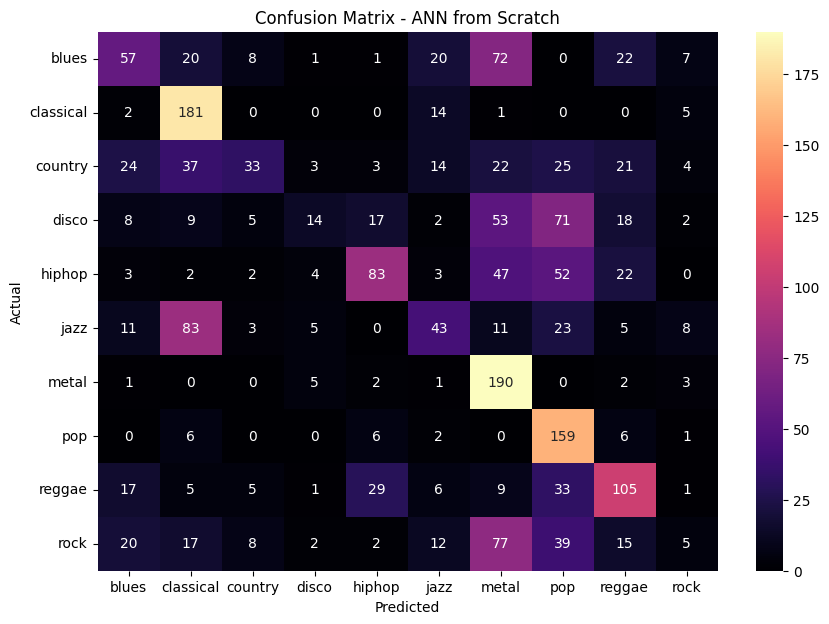


Classification Report:

              precision    recall  f1-score   support

       blues       0.40      0.27      0.32       208
   classical       0.50      0.89      0.64       203
     country       0.52      0.18      0.26       186
       disco       0.40      0.07      0.12       199
      hiphop       0.58      0.38      0.46       218
        jazz       0.37      0.22      0.28       192
       metal       0.39      0.93      0.55       204
         pop       0.40      0.88      0.55       180
      reggae       0.49      0.50      0.49       211
        rock       0.14      0.03      0.04       197

    accuracy                           0.44      1998
   macro avg       0.42      0.44      0.37      1998
weighted avg       0.42      0.44      0.37      1998



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_train_oh = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test_oh = ohe.transform(y_test.values.reshape(-1, 1))

# Neural Network from scratch
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            # Xavier Initialization
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(1. / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, x):
        return np.where(x > 0, x, 0.01 * x)  # Leaky ReLU

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0.01)  # Leaky ReLU Derivative

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            a = self.relu(z)
            activations.append(a)
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        z_values.append(z)
        a = self.softmax(z)
        activations.append(a)
        return activations, z_values

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, activations, z_values, y_true):
        grads_w = [0] * len(self.weights)
        grads_b = [0] * len(self.biases)
        m = y_true.shape[0]
        delta = activations[-1] - y_true

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(activations[i].T, delta) / m
            grads_b[i] = np.sum(delta, axis=0, keepdims=True) / m

            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(z_values[i - 1])

        return grads_w, grads_b

    def update_parameters(self, grads_w, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def fit(self, X, y, epochs=300):
        for epoch in range(epochs):
            activations, z_values = self.forward(X)
            loss = self.compute_loss(y, activations[-1])
            grads_w, grads_b = self.backward(activations, z_values, y)
            self.update_parameters(grads_w, grads_b)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

# Train model
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=10, learning_rate=0.005)
nn.fit(X_train, y_train_oh, epochs=300)

# Predict
train_preds = nn.predict(X_train)
test_preds = nn.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, train_preds) * 100
test_acc = accuracy_score(y_test, test_preds) * 100
print(f"\nTrain Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ANN from Scratch")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))

## Model 5: ANN using pytorch for increased accuracy


Epoch 1/80, Loss: 1.2057
Epoch 5/80, Loss: 0.6344
Epoch 10/80, Loss: 0.4648
Epoch 15/80, Loss: 0.3812
Epoch 20/80, Loss: 0.2795
Epoch 25/80, Loss: 0.2424
Epoch 30/80, Loss: 0.2314
Epoch 35/80, Loss: 0.1818
Epoch 40/80, Loss: 0.1780
Epoch 45/80, Loss: 0.1693
Epoch 50/80, Loss: 0.1558
Epoch 55/80, Loss: 0.1486
Epoch 60/80, Loss: 0.1383
Epoch 65/80, Loss: 0.1275
Epoch 70/80, Loss: 0.1313
Epoch 75/80, Loss: 0.1318
Epoch 80/80, Loss: 0.1203

Test Accuracy: 93.57%


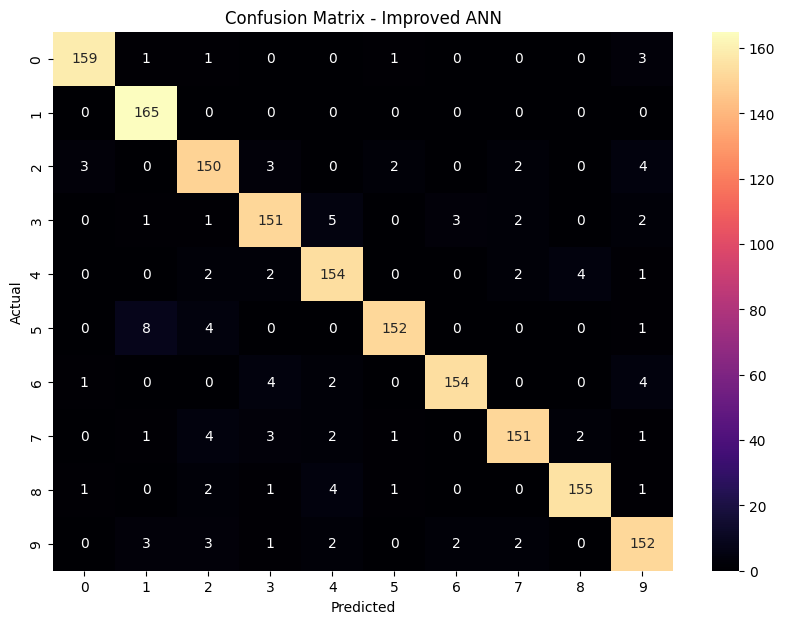

In [ ]:
# Model 5: Artificial Neural Network (ANN)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets & loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the ANN model with enhancements
class ImprovedANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImprovedANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
ann_model = ImprovedANN(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann_model.to(device)

# Training loop
epochs = 80
for epoch in range(epochs):
    ann_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = ann_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
ann_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = ann_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Improved ANN")
plt.show()

# Save the model
# os.makedirs("models", exist_ok=True)
# torch.save({
#     'model_state_dict': ann_model.state_dict(),
#     'input_dim': input_dim,
#     'output_dim': output_dim
# }, 'models/ann_model.pth')

In [ ]:
# from google.colab import files
# files.download('models/ann_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import joblib

# Save as a .pkl file
# joblib.dump({
#   'model': knn_model,
#   'scaler': scaler,
#   'label_encoder': label_encoder
# }, 'knn_model.pkl')

['ann_model.pkl']

In [ ]:
# from google.colab import files
# files.download('knn_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>